In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
torch.cuda.is_available()

True

In [ ]:
!git clone https://github.com/ContinualAI/colab.git continualai/colab

Cloning into 'continualai/colab'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 378 (delta 78), reused 64 (delta 62), pack-reused 258
Receiving objects: 100% (378/378), 26.97 MiB | 13.52 MiB/s, done.
Resolving deltas: 100% (198/198), done.


In [ ]:
from continualai.colab.scripts import mnist
mnist.init()

Download complete.
Save complete.


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



In [ ]:
x_train, t_train, x_test, t_test = mnist.load()

print("x_train dim and type: ", x_train.shape, x_train.dtype)
print("t_train dim and type: ", t_train.shape, t_train.dtype)
print("x_test dim and type: ", x_test.shape, x_test.dtype)
print("t_test dim and type: ", t_test.shape, t_test.dtype)

x_train dim and type:  (60000, 1, 28, 28) float32
t_train dim and type:  (60000,) uint8
x_test dim and type:  (10000, 1, 28, 28) float32
t_test dim and type:  (10000,) uint8


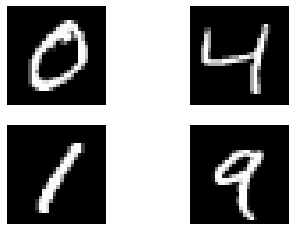

In [ ]:
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(x_train[1, 0], cmap="gray")
axarr[0,1].imshow(x_train[2, 0], cmap="gray")
axarr[1,0].imshow(x_train[3, 0], cmap="gray")
axarr[1,1].imshow(x_train[4, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [ ]:
use_cuda = True

use_cuda = use_cuda and torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu");
torch.manual_seed(1);

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [ ]:
def train(model, device, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)
      optimizer.zero_grad()
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()
      optimizer.step()
      #print(loss.item())
    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

def test(model, device, x_test, t_test):
    model.eval()
    test_loss = 0
    correct = 0
    for start in range(0, len(t_test)-1, 256):
      end = start + 256
      with torch.no_grad():
        x, y = torch.from_numpy(x_test[start:end]), torch.from_numpy(t_test[start:end]).long()
        x, y = x.to(device), y.to(device)
        output = model(x)
        test_loss += F.cross_entropy(output, y).item()
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(y.view_as(pred)).sum().item()
    test_loss /= len(t_test)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(t_test),
        100. * correct / len(t_test)))
    return 100. * correct / len(t_test)

In [ ]:
x_train.dtype
t_train.dtype

dtype('float32')

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for epoch in range(1, 3):
  train(model, device, x_train, t_train, optimizer, epoch)
  test(model, device, x_test, t_test)

Train Epoch: 1 	Loss: 0.764338
Test set: Average loss: 0.0013, Accuracy: 9028/10000 (90%)

Train Epoch: 2 	Loss: 0.492381
Test set: Average loss: 0.0007, Accuracy: 9436/10000 (94%)



In [ ]:
def permute_mnist(mnist, seed):
    np.random.seed(seed)
    print("starting permutation...")
    h = w = 28
    perm_inds = list(range(h*w))
    np.random.shuffle(perm_inds)
    # print(perm_inds)
    perm_mnist = []
    for set in mnist:
        num_img = set.shape[0]
        flat_set = set.reshape(num_img, w * h)
        perm_mnist.append(flat_set[:, perm_inds].reshape(num_img, 1, w, h))
    print("done.")
    return perm_mnist

In [ ]:
x_train2, x_test2 = permute_mnist([x_train, x_test], 0)

starting permutation...
done.


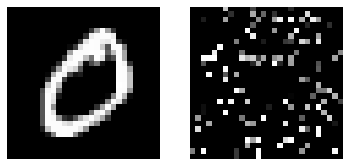

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x_train[1, 0], cmap="gray")
axarr[1].imshow(x_train2[2, 0], cmap="gray")
np.vectorize(lambda ax:ax.axis('off'))(axarr);

In [ ]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test)

Testing on the first task:
Test set: Average loss: 0.0007, Accuracy: 9436/10000 (94%)

Testing on the second task:
Test set: Average loss: 0.0108, Accuracy: 1034/10000 (10%)



In [ ]:
for epoch in range(1, 3):
  train(model, device, x_train2, t_train, optimizer, epoch)
  test(model, device, x_test2, t_test)

Train Epoch: 1 	Loss: 1.486404
Test set: Average loss: 0.0032, Accuracy: 7366/10000 (74%)

Train Epoch: 2 	Loss: 1.125475
Test set: Average loss: 0.0022, Accuracy: 8298/10000 (83%)



In [ ]:
print("Testing on the first task:")
test(model, device, x_test, t_test)

print("Testing on the second task:")
test(model, device, x_test2, t_test);

Testing on the first task:
Test set: Average loss: 0.0210, Accuracy: 2319/10000 (23%)

Testing on the second task:
Test set: Average loss: 0.0022, Accuracy: 8298/10000 (83%)



In [ ]:
# task 1
task_1 = [(x_train, t_train), (x_test, t_test)]

# task 2
x_train2, x_test2 = permute_mnist([x_train, x_test], 1)
task_2 = [(x_train2, t_train), (x_test2, t_test)]

# task 3
x_train3, x_test3 = permute_mnist([x_train, x_test], 2)
task_3 = [(x_train3, t_train), (x_test3, t_test)]

# task list
tasks = [task_1, task_2, task_3]

starting permutation...
done.
starting permutation...
done.


In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
naive_accs = []

for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)

  (x_train, t_train), _ = task

  for epoch in range(1, 2):
    train(model, device, x_train, t_train, optimizer, epoch)

  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc

  naive_accs.append(avg_acc / 3)
  print("Avg acc: ", avg_acc / 3)


Training on task:  0
Train Epoch: 1 	Loss: 0.659434
Testing on task:  0
Test set: Average loss: 0.0013, Accuracy: 9027/10000 (90%)

Testing on task:  1
Test set: Average loss: 0.0113, Accuracy: 625/10000 (6%)

Testing on task:  2
Test set: Average loss: 0.0101, Accuracy: 1250/10000 (12%)

Avg acc:  36.339999999999996
Training on task:  1
Train Epoch: 1 	Loss: 1.734729
Testing on task:  0
Test set: Average loss: 0.0138, Accuracy: 1850/10000 (18%)

Testing on task:  1
Test set: Average loss: 0.0051, Accuracy: 6356/10000 (64%)

Testing on task:  2
Test set: Average loss: 0.0100, Accuracy: 1218/10000 (12%)

Avg acc:  31.413333333333338
Training on task:  2
Train Epoch: 1 	Loss: 1.621491
Testing on task:  0
Test set: Average loss: 0.0261, Accuracy: 1475/10000 (15%)

Testing on task:  1
Test set: Average loss: 0.0076, Accuracy: 3407/10000 (34%)

Testing on task:  2
Test set: Average loss: 0.0038, Accuracy: 7195/10000 (72%)

Avg acc:  40.25666666666667


In [ ]:
def shuffle_in_unison(dataset, seed, in_place=False):
    """ Shuffle two (or more) list in unison. """

    np.random.seed(seed)
    rng_state = np.random.get_state()
    new_dataset = []
    for x in dataset:
        if in_place:
            np.random.shuffle(x)
        else:
            new_dataset.append(np.random.permutation(x))
        np.random.set_state(rng_state)

    if not in_place:
        return new_dataset

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:


rehe_accs = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task: ", id)

  (x_train, t_train), _ = task

  # for previous task
  for i in range(id):
    (past_x_train, past_t_train), _ = tasks[i]
    x_train = np.concatenate((x_train, past_x_train))
    t_train = np.concatenate((t_train, past_t_train))

  x_train, t_train = shuffle_in_unison([x_train, t_train], 0)

  for epoch in range(1, 2):
    train(model, device, x_train, t_train, optimizer, epoch)

  for id_test, task in enumerate(tasks):
    print("Testing on task: ", id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc

  print("Avg acc: ", avg_acc / 3)
  rehe_accs.append(avg_acc/3)



Training on task:  0
Train Epoch: 1 	Loss: 0.586375
Testing on task:  0
Test set: Average loss: 0.0014, Accuracy: 9054/10000 (91%)

Testing on task:  1
Test set: Average loss: 0.0113, Accuracy: 588/10000 (6%)

Testing on task:  2
Test set: Average loss: 0.0101, Accuracy: 1044/10000 (10%)

Avg acc:  35.62
Training on task:  1
Train Epoch: 1 	Loss: 0.843866
Testing on task:  0
Test set: Average loss: 0.0008, Accuracy: 9416/10000 (94%)

Testing on task:  1
Test set: Average loss: 0.0036, Accuracy: 7499/10000 (75%)

Testing on task:  2
Test set: Average loss: 0.0102, Accuracy: 1072/10000 (11%)

Avg acc:  59.956666666666656
Training on task:  2
Train Epoch: 1 	Loss: 0.531836
Testing on task:  0
Test set: Average loss: 0.0006, Accuracy: 9506/10000 (95%)

Testing on task:  1
Test set: Average loss: 0.0021, Accuracy: 8499/10000 (85%)

Testing on task:  2
Test set: Average loss: 0.0024, Accuracy: 8249/10000 (82%)

Avg acc:  87.51333333333334


In [ ]:
fisher_dict = {}
optpar_dict = {}
ewc_lambda = 0.4

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def on_task_update(task_id, x_mem, t_mem):

  model.train()
  optimizer.zero_grad()

  # accumulating gradients
  for start in range(0, len(t_mem)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_mem[start:end]), torch.from_numpy(t_mem[start:end]).long()
      x, y = x.to(device), y.to(device)
      output = model(x)
      loss = F.cross_entropy(output, y)
      loss.backward()

  fisher_dict[task_id] = {}
  optpar_dict[task_id] = {}

  # gradients accumulated can be used to calculate fisher
  for name, param in model.named_parameters():

    optpar_dict[task_id][name] = param.data.clone()
    fisher_dict[task_id][name] = param.grad.data.clone().pow(2)

In [ ]:
"""EWC"""


def train_ewc(model, device, task_id, x_train, t_train, optimizer, epoch):
    model.train()

    for start in range(0, len(t_train)-1, 256):
      end = start + 256
      x, y = torch.from_numpy(x_train[start:end]), torch.from_numpy(t_train[start:end]).long()
      x, y = x.to(device), y.to(device)

      optimizer.zero_grad()

      output = model(x)
      loss = F.cross_entropy(output, y)

      for task in range(task_id):
        for name, param in model.named_parameters():
          fisher = fisher_dict[task][name]
          optpar = optpar_dict[task][name]
          loss += (fisher * (optpar - param).pow(2)).sum() * ewc_lambda

      loss.backward()
      optimizer.step()

    print('Train Epoch: {} \tLoss: {:.6f}'.format(epoch, loss.item()))

In [ ]:
ewc_accs = []
for id, task in enumerate(tasks):
  avg_acc = 0
  print("Training on task-",id)
  (x_train, t_train), _ = task
  for epoch in range(1, 3):
    train_ewc(model, device, id, x_train, t_train, optimizer, epoch)
  on_task_update(id, x_train, t_train)
  for id_test, task in enumerate(tasks):
    print("Testing on task-",id_test)
    _, (x_test, t_test) = task
    acc = test(model, device, x_test, t_test)
    avg_acc = avg_acc + acc
  print("Avg acc: ", avg_acc / 3)
  ewc_accs.append(avg_acc / 3)

Training on task- 0
Train Epoch: 1 	Loss: 0.521313
Train Epoch: 2 	Loss: 0.365007
Testing on task- 0
Test set: Average loss: 0.0004, Accuracy: 9700/10000 (97%)

Testing on task- 1
Test set: Average loss: 0.0090, Accuracy: 2202/10000 (22%)

Testing on task- 2
Test set: Average loss: 0.0067, Accuracy: 4387/10000 (44%)

Avg acc:  54.29666666666666
Training on task- 1
Train Epoch: 1 	Loss: 1.278264
Train Epoch: 2 	Loss: 1.027598
Testing on task- 0
Test set: Average loss: 0.0017, Accuracy: 8644/10000 (86%)

Testing on task- 1
Test set: Average loss: 0.0016, Accuracy: 8837/10000 (88%)

Testing on task- 2
Test set: Average loss: 0.0100, Accuracy: 1976/10000 (20%)

Avg acc:  64.85666666666667
Training on task- 2
Train Epoch: 1 	Loss: 1.685426
Train Epoch: 2 	Loss: 1.390574
Testing on task- 0
Test set: Average loss: 0.0016, Accuracy: 8720/10000 (87%)

Testing on task- 1
Test set: Average loss: 0.0040, Accuracy: 6793/10000 (68%)

Testing on task- 2
Test set: Average loss: 0.0025, Accuracy: 8133/